> ## US Drought & Meteorological Data Starter Notebook
This notebook will walk you trough loading the data and create a Dummy Classifier, showing a range of F1 scores that correspond to random predictions if given theclass priors.

In [1]:
import os
if not os.environ.get("CUDA_VISIBLE_DEVICES"):
    os.environ.setdefault("CUDA_VISIBLE_DEVICES","1")
else:
     os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## Loading & Visualizing the Data
In this section, we load the training and validation data into numpy arrays and visualize the drought classes and meteorological attributes.

We load the json files for training, validation and testing into the ``files`` dictionary.

In [2]:
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from datetime import datetime
sns.set_style('white')

files = {}

for dirname, _, filenames in os.walk('.'):
  for filename in filenames:
    if 'train' in filename:
        files['train'] = os.path.join(dirname, filename)
    if 'valid' in filename:
        files['valid'] = os.path.join(dirname, filename)
    if 'test' in filename:
        files['test'] = os.path.join(dirname, filename)

The following classes exist, ranging from no drought (``None``), to extreme drought (``D4``).
This could be treated as a regression, ordinal or classification problem, but for now we will treat it as 5 distinct classes.

In [3]:
class2id = {
    'None': 0,
    'D0': 1,
    'D1': 2,
    'D2': 3,
    'D3': 4,
    'D4': 5,
}
id2class = {v: k for k, v in class2id.items()}

In [4]:
scaler_dict = {}
scaler_dict_static = {}
scaler_dict_past = {}

In [5]:
from sklearn.preprocessing import RobustScaler

def normalize(X_static, X_time, y_past=None, fit=False):
    for index in tqdm(range(X_time.shape[-1])):
        if fit:
            scaler_dict[index] = RobustScaler().fit(
                X_time[:,:,index].reshape(-1, 1)
            )
        X_time[:,:,index] = scaler_dict[index].transform(X_time[:,:,index].reshape(-1, 1)).reshape(-1, X_time.shape[-2])
    for index in tqdm(range(X_static.shape[-1])):
        if fit:
            scaler_dict_static[index] = RobustScaler().fit(
                X_static[:,index].reshape(-1, 1)
            )
        X_static[:,index] = scaler_dict_static[index].transform(X_static[:,index].reshape(-1, 1)).reshape(1, -1)
    index = 0
    if y_past is not None:
        if fit:
            scaler_dict_past[index] = RobustScaler().fit(
                y_past.reshape(-1, 1)
            )
        y_past[:,:] = scaler_dict_past[index].transform(y_past.reshape(-1, 1)).reshape(-1, y_past.shape[-1])
        return X_static, X_time, y_past
    return X_static, X_time

In [6]:
dfs = {
    k: pd.read_csv(files[k]).set_index(['fips', 'date'])
    for k in files.keys()
}

In [7]:
import numpy as np
from scipy.interpolate import interp1d

def interpolate_nans(padata, pkind='linear'):
    """
    see: https://stackoverflow.com/a/53050216/2167159
    """
    aindexes = np.arange(padata.shape[0])
    agood_indexes, = np.where(np.isfinite(padata))
    f = interp1d(agood_indexes
               , padata[agood_indexes]
               , bounds_error=False
               , copy=False
               , fill_value="extrapolate"
               , kind=pkind)
    return f(aindexes)

In [ ]:
# load one of 'train', 'valid' or 'test'
def loadXY(df, shuffle=True, random_state=42, window_size=180, target_size=12, fuse_past=False, past_shift=return_fips=False):
    soil_df = pd.read_csv('/kaggle/input/soil_data.csv')
    time_data_cols = sorted([c for c in df.columns if c not in ['fips','date','score']])
    static_data_cols = sorted([c for c in soil_df.columns if c not in ['soil','lat','lon']])
    count = 0
    score_df = df.dropna(subset=['score'])
    X_static = np.empty((len(df)//window_size, len(static_data_cols)))
    X_fips_date = []
    if not fuse_past:
        X_time = np.empty((len(df)//window_size, window_size, len(time_data_cols)))
    else:
        X_time = np.empty((len(df)//window_size, window_size, len(time_data_cols)+1))
    y_past = np.empty((len(df)//window_size, window_size))
    y_target = np.empty((len(df)//window_size, target_size))
    if random_state is not None:
        np.random.seed(random_state)
    for fips in tqdm(score_df.index.get_level_values(0).unique()):
        if random_state is not None:
            start_i = np.random.randint(1, window_size)
        else:
            start_i = 1
        fips_df = df[(df.index.get_level_values(0)==fips)]
        X = fips_df[time_data_cols].values
        y = fips_df['score'].values
        X_s = soil_df[soil_df['fips']==fips][static_data_cols].values[0]
        for i in range(start_i, len(y)-(window_size+target_size*7), window_size):
            X_fips_date.append((fips,fips_df.index[i:i+window_size][-1]))
            X_time[count,:,:len(time_data_cols)] = X[i:i+window_size]
            if not fuse_past:
                y_past[count] = interpolate_nans(y[i:i+window_size])
            else:
                X_time[count,:,len(time_data_cols)] = interpolate_nans(y[i:i+window_size])
            temp_y = y[i+window_size:i+window_size+target_size*7]
            y_target[count] = np.array(temp_y[~np.isnan(temp_y)][:target_size])
            X_static[count] = X_s
            count += 1
    results = [X_static[:count], X_time[:count], y_target[:count]]
    if not fuse_past:
        results.append(y_past[:count])
    if return_fips:
        results.append(X_fips_date)
    return results

**Load Training Data**

In [9]:
X_static_train, X_time_train, y_target_train = loadXY(dfs['train'], target_size=1, target_series=True)

  0%|          | 0/3108 [00:00<?, ?it/s]

- ```X_static``` are the static soil parameters (they don't change over time) (30)
- ```X_time``` are the meteorological parameters in the shape of (window_size, 18)
- ```y_past``` are previous drought classes (on the same time scale as X_time)  (windows_size, 1). Can be used as additional feature to ```X_time```
- ```y_target``` are the next x weeks of drought predictions (target_size). 

**Load Validation Data**

In [10]:
X_static_val, X_time_val, y_target_val = loadXY(dfs['valid'], target_size=1, target_series=True)

  0%|          | 0/3108 [00:00<?, ?it/s]

In [11]:
X_static_train, X_time_train = normalize(X_static_train, X_time_train, fit=True)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [12]:
X_static_val, X_time_val = normalize(X_static_val, X_time_val)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

### Inspect class imbalance

In [13]:
from collections import Counter

In [14]:
def round_array(raw_arr):
    flat_arr = raw_arr.flatten()
    arr = np.array([round(num) for num in flat_arr])
    return arr

Text(0.5, 0, 'Drought Class')

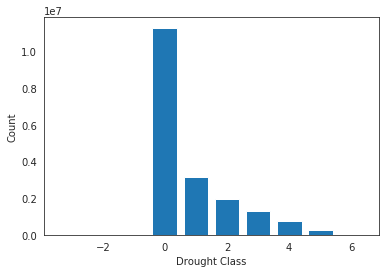

In [15]:
rounded_target = round_array(y_target_train)

class_count = Counter(rounded_target)

keys = class_count.keys()
values = class_count.values()

plt.bar(keys, values)
plt.ylabel('Count')
plt.xlabel('Drought Class')

## Load Transformer

In [17]:
import sys
sys.path.append('./ts_transformer')

In [18]:
import datetime

import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns

from tst import Transformer
from tst.loss import OZELoss
import tst.loss

from src.dataset import OzeDataset
from src.utils import compute_loss
from src.visualization import map_plot_function, plot_values_distribution, plot_error_distribution, plot_errors_threshold, plot_visual_sample

In [86]:
# Training parameters
BATCH_SIZE = 32
NUM_WORKERS = 0
LR = 0.0001
EPOCHS = 10

# Model parameters
d_model = 256 # Lattent dim
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
attention_size = 12 # Attention window size
dropout = 0.2 # Dropout rate
pe = None # Positional encoding
chunk_mode = None

d_input = 18 # From dataset
d_output = 1 # From dataset

# Config
sns.set()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda:0


In [87]:
train_with_labels = []

for i in range(len(y_target_train)):
    train_with_labels.append([X_time_train[i], y_target_train[i]])
    
val_with_labels = []
for i in range(len(y_target_val)):
    val_with_labels.append([X_time_val[i], y_target_val[i]])

In [88]:
dataloader_train = DataLoader(train_with_labels,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              pin_memory=False
                             )

dataloader_val = DataLoader(val_with_labels,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS
                           )

### Load Network

In [89]:
# Load transformer with Adam optimizer and MSE loss function
net = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, dropout=dropout, chunk_mode=chunk_mode, pe=pe).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = tst.loss.OZELoss(alpha=0.3)

### Train

In [90]:
import src.utils

In [91]:
from importlib import reload
reload(src.utils)

<module 'src.utils' from './ts_transformer/src/utils/__init__.py'>

In [92]:
net = net.float()

[Epoch   2/10]:   0%|          | 32/103939 [00:00<06:08, 281.64it/s, loss=0.963]

COMPARING LOSS
Saving


[Epoch   2/10]: 100%|██████████| 103939/103939 [06:13<00:00, 289.01it/s, loss=0.982, val_loss=0.612]

COMPARING LOSS
Saving


[Epoch   4/10]:   0%|          | 0/103939 [00:00<?, ?it/s]

COMPARING LOSS
Saving


[Epoch   5/10]:   0%|          | 32/103939 [00:00<06:13, 278.22it/s, loss=1.08]

COMPARING LOSS


[Epoch   6/10]:   0%|          | 32/103939 [00:00<06:07, 282.72it/s, loss=1.16]

COMPARING LOSS


[Epoch   7/10]:   0%|          | 32/103939 [00:00<06:10, 280.65it/s, loss=0.836]

COMPARING LOSS


[Epoch   8/10]:   0%|          | 32/103939 [00:00<06:11, 279.77it/s, loss=0.734]

COMPARING LOSS


[Epoch   9/10]:   0%|          | 32/103939 [00:00<06:15, 276.97it/s, loss=1.51]

COMPARING LOSS


[Epoch  10/10]:   0%|          | 32/103939 [00:00<06:14, 277.69it/s, loss=1.6]

COMPARING LOSS


[Epoch  10/10]: 100%|██████████| 103939/103939 [06:11<00:00, 279.72it/s, loss=0.91, val_loss=0.612]

COMPARING LOSS
model exported to models/batch_64_model_2021_03_14__112827.pth with loss 0.600864


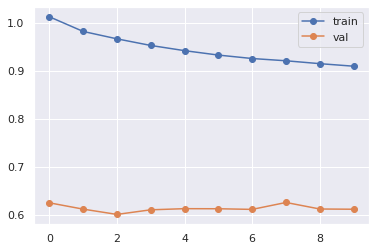

In [93]:
model_save_path = 'models/batch_64_model_{}.pth'.format(datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")) 

val_loss_best = np.inf

# Prepare loss history
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)
for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        
        for idx_batch, (x, y) in enumerate(dataloader_train):
            optimizer.zero_grad()
            # Propagate input
            netout = net(x.float().to(device))
            y = y[:,:,np.newaxis]
            # Comupte loss
            loss = loss_function(y.float().to(device), netout)
            # Backpropage loss
            loss.backward()
            # Update weights
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
            
        
        train_loss = running_loss/len(dataloader_train)
        val_loss = src.utils.compute_loss(net, dataloader_val, loss_function, device).item()
        pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        
        hist_loss[idx_epoch] = train_loss
        hist_loss_val[idx_epoch] = val_loss
        print ("COMPARING LOSS")
        if val_loss < val_loss_best:
            val_loss_best = val_loss
            print ("Saving")
            torch.save(net.state_dict(), model_save_path)
        
plt.plot(hist_loss, 'o-', label='train')
plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

model exported to models/batch_64_model_2021_03_14__112827.pth with loss 0.600864


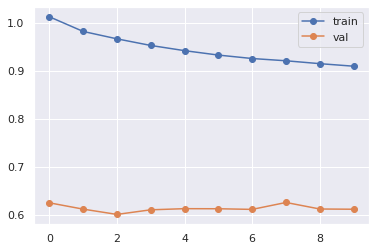

In [94]:
plt.plot(hist_loss, 'o-', label='train')
plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

**Load Test set**

In [95]:
X_static_test, X_time_test, y_past_test = loadXY(dfs['test'], target_size=1, target_series=True)

100%|██████████| 3108/3108 [00:34<00:00, 90.95it/s]


In [96]:
X_static_test, X_time_test = normalize(X_static_test, X_time_test)

100%|██████████| 30/30 [00:00<00:00, 9751.17it/s]


In [97]:
test_with_labels = []
for i in range(len(y_past_test)):
    test_with_labels.append([X_time_test[i], y_past_test[i]])

In [98]:
dataloader_test = DataLoader(test_with_labels,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS
                            )

## Validation


In [99]:
_ = net.eval()

### Evaluate on the test dataset

In [100]:
print (X_time_test.shape)

(9381, 180, 18)


In [101]:

predictions = np.empty(shape=(len(dataloader_test.dataset)))
truths = np.empty(shape=(len(dataloader_test.dataset)))

idx_prediction = 0
with torch.no_grad():
    for x, y in tqdm(dataloader_test, total=len(dataloader_test)):
        netout = net(x.float().to(device)).cpu().numpy()
        predictions[idx_prediction:idx_prediction+x.shape[0]] = netout[:,-1].flatten()
        truths[idx_prediction:idx_prediction+x.shape[0]] = y[:,-1]
        idx_prediction += x.shape[0]


100%|██████████| 294/294 [00:10<00:00, 26.82it/s]


In [102]:
test_with_labels[0][1]

array([3.71571429e-01, 4.95428571e-01, 6.19285714e-01, 7.43142857e-01,
       8.67000000e-01, 8.67000000e-01, 8.67000000e-01, 8.67000000e-01,
       8.67000000e-01, 8.67000000e-01, 8.67000000e-01, 8.67000000e-01,
       8.67000000e-01, 8.67000000e-01, 8.67000000e-01, 8.67000000e-01,
       8.67000000e-01, 8.67000000e-01, 8.67000000e-01, 7.43142857e-01,
       6.19285714e-01, 4.95428571e-01, 3.71571429e-01, 2.47714286e-01,
       1.23857143e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.14285714e-04, 1.02857143e-03,
      

### Plot results on a sample

In [118]:
from sklearn.metrics import f1_score

f1_score(truths.round(), predictions.round(), average='macro')

0.1471700117030121

({0.0, 1.0}, {-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0})

In [ ]:
print ("Precision: {:.2f}".format(prec))
print ("Recall: {:.2f}".format(rec))
print ("F1-Score: {:.2f}".format(f1))

In [ ]:
"""
Bar plot showing the number of predicted
predictions vs actual predictions for each
class
"""

pred_counter = Counter(predicted_drought_values_rounded)
true_counter = Counter(y_target_test_rounded)

classes_pred = pred_counter.keys()
classes_true = true_counter.keys()
pred_values = pred_counter.values()
true_values = true_counter.values()


ind_pred = np.arange(len(classes_pred))  # the x locations for the groups
ind_true = np.arange(len(classes_true))
width = 0.4 # the width of the bars

print (pred_counter)
fig = plt.figure()
ax = fig.add_subplot(111)

predBar = ax.bar(ind_pred, pred_values, width, color='royalblue')

trueBar = ax.bar(ind_true+width, true_values, width, color='seagreen')

ax.set_ylabel('Count')
ax.set_xticks(ind_true + width / 2)
ax.set_xticklabels(ind_true)

ax.legend( (predBar[0], trueBar[0]), ('Predicted', 'Actual') )

plt.show()

### Plot error distributions

In [ ]:
map_plot_function(y_target_test, predictions, plot_error_distribution, dataset_indices=dataloader_test.dataset.indices, time_limit=24)


### Plot mispredictions thresholds

In [ ]:
map_plot_function(y_target_test, predictions, plot_errors_threshold, plot_kwargs={'error_band': 0.1}, dataset_indices=dataloader_test.dataset.indices)
